## Importing libraries

In [37]:
import numpy as np
import pandas as pd
import os, random
import cv2
import collections
import time
import tqdm
from PIL import Image
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import TensorDataset, DataLoader,Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingLR

import albumentations as albu
from albumentations import pytorch as AT
from efficientnet_pytorch import EfficientNet
from efficientnet_pytorch.utils import Conv2dStaticSamePadding

from catalyst.data import Augmentor
from catalyst.dl import utils
from catalyst.data.reader import ImageReader, ScalarReader, ReaderCompose, LambdaReader
from catalyst.dl.runner import SupervisedRunner
from catalyst.dl.callbacks import AccuracyCallback, EarlyStoppingCallback, InferCallback, CheckpointCallback, MixupCallback
from catalyst.dl.core.callback import MetricCallback
from catalyst.utils import set_global_seed, prepare_cudnn
from catalyst.dl import utils
from catalyst.dl.runner import SupervisedRunner
from catalyst.contrib.criterion import FocalLossMultiClass
from catalyst.contrib.schedulers import OneCycleLRWithWarmup

from datetime import datetime
from torchsummary import summary
from imblearn.over_sampling import SMOTE

torch.backends.cudnn.benchmark = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


SEED = 255  # FF
set_global_seed(SEED)

## Data overview

In [38]:
path = './'
train = pd.read_csv('./train_labels1979to1980.csv', header=None, names=["id", "label"])
train['label'] = train['label'] - 1980
time_run = datetime.now().strftime('%Y%m%d_%H%M%S')
logdir = "./results/"+ time_run
os.makedirs(logdir, exist_ok=True)

num_class = 39

In [39]:
train.head()


,id,label
0,train_0001.png,32
1,train_0002.png,23
2,train_0003.png,14
3,train_0004.png,34
4,train_0005.png,23


In [40]:
n_train = len(os.listdir(f'{path}/train_images'))
n_test = len(os.listdir(f'{path}/test_images'))
print(f'There are {n_train} images in train dataset')
print(f'There are {n_test} images in test dataset')

There are 6686 images in train dataset
There are 1671 images in test dataset


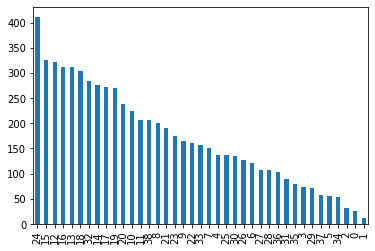

In [41]:
train['label'].value_counts().plot(kind="bar")

## Dataset

In [42]:
class FFDataset(Dataset):
    def __init__(self, df: pd.DataFrame = None, datatype: str = 'train',
                 transforms=albu.Compose([albu.HorizontalFlip(), AT.ToTensor()]), ):

        self.df = df
        self.data = df['id']
        self.label = df['label']
        if datatype != 'test':
            self.data_folder = f"{path}/train_images"
        else:
            self.data_folder = f"{path}/test_images"
        self.transforms = transforms

    def __getitem__(self, idx):
        image_name = self.data[idx]
        image_path = os.path.join(self.data_folder, image_name)
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        augmented = self.transforms(image=img)
        org_img = augmented['image']
        label = self.label[idx]
        
        ''' fourier transform input data
        f = np.fft.fft2(org_img)
        fr = f.real
        fr = torch.from_numpy(fr).float()
        fi = f.imag
        fi = torch.from_numpy(fi).float()
        img = torch.cat((org_img, fr, fi), 0)
        
        return img, label
        '''
        return org_img, label
        

    def __len__(self):
        return len(self.df)

In [51]:
def score_fn(output, target):
    '''
    -targets is a tensor: batch_size
    -outputs is a tensor: batch_size x num_classes
    torch.Size([32, 39])
target--- tensor([10, 24, 14, 24, 29, 33,  8, 32, 15,  8, 17, 18, 14, 38, 19, 11, 10, 14,
        30, 18, 14, 24, 10, 36, 10, 24, 28, 11, 38, 13, 26, 26],
       device='cuda:0')
torch.Size([32])
    
    '''
    _, idx = torch.max(output, 1)
    
    
    print("output---", output)
    print(output.shape)
    print("target---", target)
    print(target.shape)
#    y_pred = tf.math.argmax(y_pred, axis=-1, output_type="int32")
#    return tf.cast(tf.less_equal(tf.math.abs(y_true - y_pred), 1), "float32")
    score = 1
    return score

'''
    activation_fn = get_activation_fn(activation)
    outputs = activation_fn(outputs)

    if threshold:
        outputs = (outputs > threshold).long()

    # multi-label classification
    if len(targets.shape) > 1 and targets.size(1) > 1:
        res = (targets.long() == outputs.long()).sum().float() / np.prod(
            targets.shape)
        return [res]

    max_k = max(topk)
    batch_size = targets.size(0)

    if len(outputs.shape) == 1 or outputs.shape[1] == 1:
        pred = outputs.t()
    else:
        _, pred = outputs.topk(max_k, 1, True, True)
        pred = pred.t()
    correct = pred.eq(targets.long().view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res
'''

'\n    activation_fn = get_activation_fn(activation)\n    outputs = activation_fn(outputs)\n\n    if threshold:\n        outputs = (outputs > threshold).long()\n\n    # multi-label classification\n    if len(targets.shape) > 1 and targets.size(1) > 1:\n        res = (targets.long() == outputs.long()).sum().float() / np.prod(\n            targets.shape)\n        return [res]\n\n    max_k = max(topk)\n    batch_size = targets.size(0)\n\n    if len(outputs.shape) == 1 or outputs.shape[1] == 1:\n        pred = outputs.t()\n    else:\n        _, pred = outputs.topk(max_k, 1, True, True)\n        pred = pred.t()\n    correct = pred.eq(targets.long().view(1, -1).expand_as(pred))\n\n    res = []\n    for k in topk:\n        correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)\n        res.append(correct_k.mul_(100.0 / batch_size))\n    return res\n'

In [52]:
img_height = 256
img_width = 256

# train用のデータ拡張
data_transforms = albu.Compose([
    albu.Resize(img_height, img_width),
    albu.HorizontalFlip(p=0.5),
    albu.VerticalFlip(p=0.5),
    albu.RandomBrightnessContrast(p=0.3),
    albu.RandomGamma(gamma_limit=(85, 115), p=0.3),
    albu.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.10, rotate_limit=45, p=0.5),
    albu.GaussNoise(var_limit=(10.0, 50.0), mean=0, p=0.5),   # white noise shouuld be a useful data aug
    albu.Normalize(),
    AT.ToTensor()
])

# test用のデータ拡張
data_transforms_test = albu.Compose([
    albu.Resize(img_height, img_width),
    albu.Normalize(),
    AT.ToTensor()
    ])

In [53]:
# 学習データを訓練用と検証用に分割


skf = StratifiedKFold(n_splits=10, random_state=SEED)
train_index, test_index = skf.split(train['id'], train['label']).__next__()

train_df = train.iloc[train_index].reset_index(drop=True)
valid_df = train.iloc[test_index].reset_index(drop=True)

#Oversampling using SMOTE
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(train_index.reshape(-1, 1), train_df['label'].to_list()) #Resample and expand the train_index
train_df_res = train.iloc[X_res.reshape(-1,)].reset_index(drop=True)

train_dataset = FFDataset(df=train_df_res, datatype='train', transforms=data_transforms)
valid_dataset = FFDataset(df=valid_df, datatype='valid', transforms=data_transforms_test)

num_workers = 0
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

loaders = collections.OrderedDict()
loaders["train"] = train_loader
loaders["valid"] = valid_loader

C:\Users\silas\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning:

Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.



## Model

In [57]:
#model = Resnet(num_class)
#model = CustomEfficientNet(num_classes=num_class, in_chan=9)
model = EfficientNet.from_pretrained('efficientnet-b3', num_classes=num_class, in_channels=3)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, factor=0.5, patience=3, min_lr=1e-6, verbose=True)

Loaded pretrained weights for efficientnet-b3


## Model training

In [58]:
print(logdir)
# model runner
num_epochs = 2
runner = SupervisedRunner()

#resume_dir=None

# model training
runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    loaders=loaders,
    callbacks=[
               AccuracyCallback(num_classes=num_class, accuracy_args=[1,3]),
               # EarlyStoppingCallback(patience=5, min_delta=0.001),
               # MetricCallback(prefix='score', metric_fn=score_fn),     #score_fn not yet finished
               CheckpointCallback(save_n_best=num_epochs, resume_dir=None),
               ],
    logdir=logdir,
    num_epochs=num_epochs,
    main_metric='accuracy01',
    verbose=True
    )

./year_estimate/results/20200102_224826


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>



1/2 * Epoch (train):   0% 0/451 [00:00<?, ?it/s]output--- tensor([[-0.1428, -0.1744,  0.1557,  ...,  0.1654,  0.1323,  0.2289],
        [-0.0893, -0.0691, -0.0325,  ...,  0.0191, -0.0731, -0.1531],
        [ 0.1903, -0.2082, -0.0559,  ...,  0.0234, -0.0843, -0.0803],
        ...,
        [-0.2532, -0.3687,  0.0598,  ..., -0.1315,  0.0184,  0.0807],
        [ 0.0871,  0.0726,  0.2450,  ...,  0.0029,  0.1955, -0.3520],
        [ 0.0135,  0.3872,  0.1364,  ...,  0.2472, -0.1437,  0.1228]],
       device='cuda:0', grad_fn=<AddmmBackward>)
torch.Size([32, 39])
target--- tensor([10, 24, 14, 24, 29, 33,  8, 32, 15,  8, 17, 18, 14, 38, 19, 11, 10, 14,
        30, 18, 14, 24, 10, 36, 10, 24, 28, 11, 38, 13, 26, 26],
       device='cuda:0')
torch.Size([32])


1/2 * Epoch (train):   0% 0/451 [00:00<?, ?it/s, accuracy01=3.125, accuracy03=3.125, loss=3.711, score=1.000]

1/2 * Epoch (train):   0% 1/451 [00:00<05:01,  1.49it/s, accuracy01=3.125, accuracy03=3.125, loss=3.711, score=1.000]output--- 

## Predicting

In [36]:
submission = pd.read_csv('sample_submission.csv', header=None, names=["id", "label"])

test_dataset = FFDataset(df=submission, datatype='test', transforms=data_transforms_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [40]:
model.eval()
predictions = runner.predict_loader(
    model=model,
    loader=test_loader,
    resume=f"{logdir}/checkpoints/53.pth",
    verbose=True
    )

# print(predictions.shape)

=> loading checkpoint ./year_estimate/results/20191231_164819/checkpoints/53.pth
loaded checkpoint ./year_estimate/results/20191231_164819/checkpoints/53.pth (epoch 53)
1/1 * Epoch (infer): 100% 53/53 [00:09<00:00,  5.88it/s]
Top best models:



In [41]:
class_names = sorted(list(train['label'].unique()))
pred_list = []
for i in range(n_test):
    probabilities = torch.softmax(torch.from_numpy(predictions[i]), dim=0)
    label = probabilities.argmax().item()
    pred_list.append(class_names[label] + 1980)

In [42]:
submission['label'] = pred_list
submission.to_csv(f"{logdir}/submission.csv", header=False, index=False)